In [122]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pathlib import Path
from PIL import Image
import os

## Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## tensorflow & Keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

In [123]:
from zipfile import ZipFile
with ZipFile('/dataset/train.zip', 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [ ]:
from zipfile import ZipFile
with ZipFile('/dataset/test.zip', 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
  
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall()
    print('Done!')

In [124]:
train_df = pd.read_csv('/dataset/train.csv')
train_df.head()

,id,label
0,0,24
1,1,2
2,2,17
3,3,14
4,4,19


In [125]:
alpha = 'أ ب ت ث ج ح خ د ذ ر ز س ش ص ض ط ظ ع غ ف ق ك ل م ن هـ و ي'
alpha = alpha.split()
m = {i+1: alpha[i] for i in range(len(alpha))}
len(alpha)

28

In [126]:
train_df['alpha'] = train_df.label.map(m)

train_df.head()


,id,label,alpha
0,0,24,م
1,1,2,ب
2,2,17,ظ
3,3,14,ص
4,4,19,غ


In [127]:
train_imagas_path = Path(r'/dataset/train')



In [128]:
## read these all training images paths as Series
train_images_paths = pd.Series(sorted(list(train_imagas_path.glob(r'*.png'))), name='Filepath').astype(str)

train_images_paths.head()


0    /content/train/00000.png
1    /content/train/00001.png
2    /content/train/00002.png
3    /content/train/00003.png
4    /content/train/00004.png
Name: Filepath, dtype: object

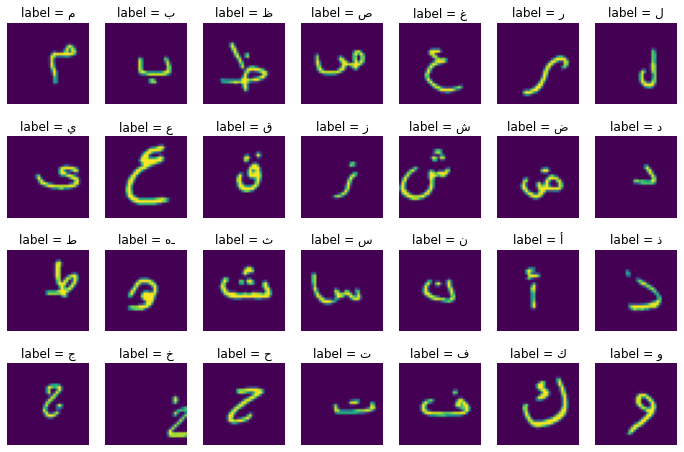

In [129]:
img_key_value = {}
for value in train_df['alpha'].unique():
    img_key_value[value] = train_df[train_df['alpha']==value].index[0]
    
img_index = list(img_key_value.values())
img_label = list(img_key_value.keys())

fig, ax = plt.subplots(4, 7, figsize=(12, 8))

i = 0
for row in range(4):
    for col in range(7):
        plt.sca(ax[row, col])
        plt.title(f'label = {img_label[i]}')
        img = plt.imread(train_images_paths.iloc[img_index[i]])
        plt.imshow(img)
        plt.axis('off')
        i+=1

In [130]:
img = plt.imread(train_images_paths.iloc[img_index[0]])
print('shape of each Image is =>', img.shape)

shape of each Image is => (32, 32, 4)


**From the previous EDA we can conclude that we can take only the first 3 channels and some data augmentation techniques may make the model performs better.**

In [131]:

train_full_labels = train_df['label'].values
train_full_set = np.empty((13440, 32, 32, 3), dtype=np.float32)  #take only the first 3 channels

for idx, path in enumerate(train_images_paths):
    img = plt.imread(path)
    img = img[:,:,:3]
    train_full_set[idx] = img

print('train_full_set.shape =>', train_full_set.shape)
print('train_full_labels.shape =>', train_full_labels.shape)


train_full_set.shape => (13440, 32, 32, 3)
train_full_labels.shape => (13440,)


In [132]:
X_train, X_valid, y_train, y_valid = train_test_split(train_full_set, train_full_labels, test_size=0.2, shuffle=True, random_state=42)

print('X_train.shape =>', X_train.shape)
print('X_valid.shape =>', X_valid.shape)
print('y_train.shape =>', y_train.shape)
print('y_valid.shape =>', y_valid.shape)

X_train.shape => (10752, 32, 32, 3)
X_valid.shape => (2688, 32, 32, 3)
y_train.shape => (10752,)
y_valid.shape => (2688,)


# **Modeling**

In [133]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu',input_shape=(32, 32, 3)),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding="same"),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding="same"),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=(1, 1)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu',padding="same"),
    tf.keras.layers.Conv2D(filters=128, kernel_size=3, padding="valid", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=(1, 1)),
     
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu',padding="same" ),
    tf.keras.layers.Conv2D(filters=256, kernel_size=3, padding="valid", activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2,strides=(1, 1)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(29, activation='softmax')
 
])

In [134]:
model.save('../Model') #Save model for further use
model1 = tf.keras.models.load_model('../Model')
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

INFO:tensorflow:Assets written to: ../Model/assets


In [135]:
history = model1.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=128)

Epoch 1/100
84/84 [==============================] - 20s 228ms/step - loss: 1.9971 - accuracy: 0.4039 - val_loss: 1.1618 - val_accuracy: 0.6447
Epoch 2/100
84/84 [==============================] - 20s 239ms/step - loss: 0.8027 - accuracy: 0.7517 - val_loss: 0.6202 - val_accuracy: 0.8028
Epoch 3/100
84/84 [==============================] - 19s 224ms/step - loss: 0.4313 - accuracy: 0.8645 - val_loss: 0.3960 - val_accuracy: 0.8791
Epoch 4/100
84/84 [==============================] - 19s 224ms/step - loss: 0.2651 - accuracy: 0.9172 - val_loss: 0.3408 - val_accuracy: 0.8981
Epoch 5/100
84/84 [==============================] - 20s 239ms/step - loss: 0.1917 - accuracy: 0.9376 - val_loss: 0.3634 - val_accuracy: 0.8962
Epoch 6/100
84/84 [==============================] - 19s 224ms/step - loss: 0.1463 - accuracy: 0.9519 - val_loss: 0.3002 - val_accuracy: 0.9178
Epoch 7/100
84/84 [==============================] - 20s 238ms/step - loss: 0.1112 - accuracy: 0.9634 - val_loss: 0.2404 - val_accuracy:

**Error Analysis**

(0.0, 1.0)

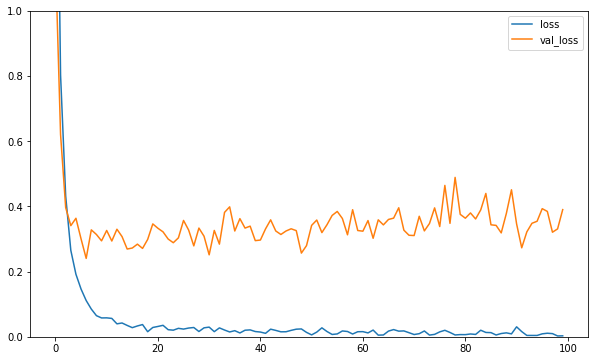

In [136]:
subset = {key: history.history[key] for key in ['loss','val_loss']}
ax = pd.DataFrame(subset).plot(figsize=(10, 6));
ax.set_ylim(0,1)

**From the above figure we can conclude that there is a gap between training loss and validation loss which is interpreted as overfitting. So, we have to try applying data augmentation to reduce this overfitting**

In [137]:
loss_val_data, acc_val_data = model1.evaluate(X_valid, y_valid, verbose=0)
print(f"acc_val_data = {acc_val_data}")


acc_val_data = 0.9549851417541504


**2- CNN + Data Augmentation**

In [138]:
model2 = tf.keras.models.load_model('../Model')
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [139]:
datagen = ImageDataGenerator(rotation_range=10,     # randomly rotate images in the range (degrees, 0 to 10)
                            zoom_range = 0.1,       # Randomly zoom image 
                            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                            height_shift_range=0.1, # randomly shift images vertically (fraction of total height)
                            validation_split = 0.1) # randomly flip images

**Here, traditional transformations are used that consist of using a combination of affine transformations to manipulate the training data. For each input image, we generate a ”duplicate” image that is rotated, zoomed in/out, shifted, and flipped. Both image and duplicate are fed into the predefined model**

In [140]:
history2 = model2.fit(datagen.flow(X_train, y_train, batch_size=128), validation_data=(X_valid, y_valid), epochs=100)

Epoch 1/100
84/84 [==============================] - 20s 230ms/step - loss: 2.7486 - accuracy: 0.1955 - val_loss: 1.7330 - val_accuracy: 0.4364
Epoch 2/100
84/84 [==============================] - 19s 227ms/step - loss: 1.6659 - accuracy: 0.4732 - val_loss: 0.8070 - val_accuracy: 0.7403
Epoch 3/100
84/84 [==============================] - 19s 228ms/step - loss: 0.9168 - accuracy: 0.7128 - val_loss: 0.4434 - val_accuracy: 0.8583
Epoch 4/100
84/84 [==============================] - 19s 228ms/step - loss: 0.5964 - accuracy: 0.8126 - val_loss: 0.3239 - val_accuracy: 0.9048
Epoch 5/100
84/84 [==============================] - 19s 228ms/step - loss: 0.4273 - accuracy: 0.8674 - val_loss: 0.2518 - val_accuracy: 0.9219
Epoch 6/100
84/84 [==============================] - 19s 227ms/step - loss: 0.3594 - accuracy: 0.8894 - val_loss: 0.2064 - val_accuracy: 0.9397
Epoch 7/100
84/84 [==============================] - 19s 227ms/step - loss: 0.2709 - accuracy: 0.9178 - val_loss: 0.1624 - val_accuracy:

(0.0, 1.0)

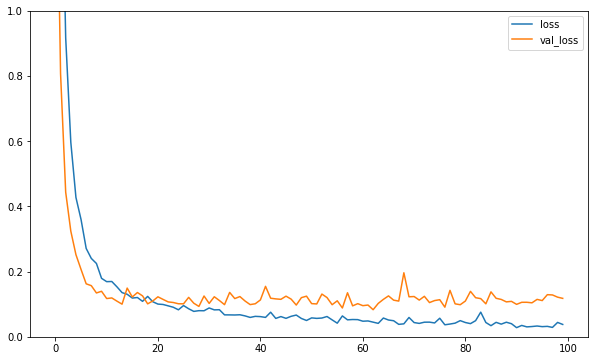

In [141]:
subset2 = {key: history2.history[key] for key in ['loss','val_loss']}
ax = pd.DataFrame(subset2).plot(figsize=(10, 6));
ax.set_ylim(0,1)

In [142]:
loss_val_data, acc_val_data = model2.evaluate(X_valid, y_valid, verbose=0)
print(f"acc_val_data = {acc_val_data}")

acc_val_data = 0.9780505895614624


#**Test Dataset**

In [143]:
test_df = pd.read_csv('/dataset/test.csv')


In [144]:
## read these all training images paths as Series
test_imagas_path = Path(r'/dataset/test')


test_images_paths = pd.Series(sorted(list(test_imagas_path.glob(r'*.png'))), name='Filepath').astype(str)
test_full_set = np.empty((3360, 32, 32, 3), dtype=np.float32)  #take only the first 3 channels

for idx, path in enumerate(test_images_paths):
    img = plt.imread(path)
    img = img[:,:,:3]
    test_full_set[idx] = img

print('train_full_set.shape =>', test_full_set.shape)


train_full_set.shape => (3360, 32, 32, 3)


In [145]:
lebel_predict = model2.predict(test_full_set)
testPredections = np.argmax(lebel_predict,axis=1)
test_df['label']=testPredections
test_df['alpha'] = test_df.label.map(m)

Prediction:  ر  letter


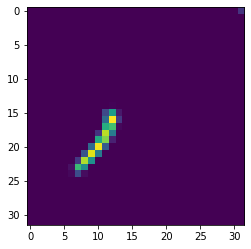

In [150]:
img = load_img('test/00001.png',color_mode='grayscale')
plt.imshow(img)

p = test_df['alpha'][1]
print('Prediction: ',p,' letter') 


Prediction:  أ  letter


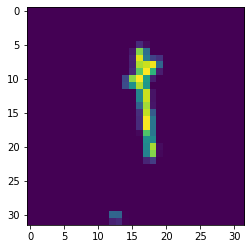

In [151]:
img = load_img('test/00002.png',color_mode='grayscale')
plt.imshow(img)

p = test_df['alpha'][2]
print('Prediction: ',p,' letter') 

Prediction:  ض  letter


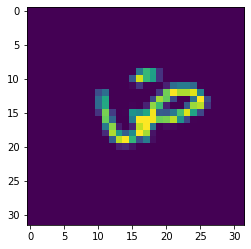

In [152]:
img = load_img('test/00004.png',color_mode='grayscale')
plt.imshow(img)

p = test_df['alpha'][4]
print('Prediction: ',p,' letter') 